# BCI Competition IV Dataset 2a - Deep Exploratory Data Analysis (EDA)

In [3]:
!pip install mne matplotlib numpy pandas scipy scikit-learn seaborn

  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl (8.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ----------------------------- 1/4 [joblib]
   ---------- ------------------------


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings('ignore')

mne.set_log_level('WARNING')  # reduce verbose output
print(f"MNE Version: {mne.__version__}")
print("All imports successful!")

MNE Version: 1.11.0
All imports successful!


In [5]:
DATA_PATH = 'data/'
SUBJECT = 'A01T'
file_path = f'{DATA_PATH}{SUBJECT}.gdf'

raw = mne.io.read_raw_gdf(
    file_path, 
    preload=True,
    eog=['EOG-left', 'EOG-central', 'EOG-right']
)

print("✅ File loaded successfully!")

✅ File loaded successfully!


In [8]:
print("=" * 50)
print("        DATASET OVERVIEW")
print("=" * 50)
print(f"Subject          : {SUBJECT}")
print(f"Sampling Rate    : {raw.info['sfreq']} Hz")
print(f"Total Channels   : {len(raw.ch_names)}")
print(f"Duration         : {raw.times[-1]:.2f} seconds ({raw.times[-1]/60:.1f} mins)")
print(f"Total Timepoints : {len(raw.times)}")
print()
print("EEG Channels (22):")
print(raw.ch_names[:22])
print()
print("EOG Channels (3):")
print(raw.ch_names[22:])

        DATASET OVERVIEW
Subject          : A01T
Sampling Rate    : 250.0 Hz
Total Channels   : 25
Duration         : 2690.11 seconds (44.8 mins)
Total Timepoints : 672528

EEG Channels (22):
['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16']

EOG Channels (3):
['EOG-left', 'EOG-central', 'EOG-right']


In [9]:
# First look at raw annotations before converting to events
print("Raw annotations in file:")
print(raw.annotations)
print()
print(f"Total annotations: {len(raw.annotations)}")
print()

# See unique annotation types
unique_annotations = set(raw.annotations.description)
print("Unique annotation types found:")
for ann in sorted(unique_annotations):
    count = sum(raw.annotations.description == ann)
    print(f"  '{ann}' — appears {count} times")

Raw annotations in file:
<Annotations | 603 segments: 1023 (15), 1072 (1), 276 (1), 277 (1), 32766 ...>

Total annotations: 603

Unique annotation types found:
  '1023' — appears 15 times
  '1072' — appears 1 times
  '276' — appears 1 times
  '277' — appears 1 times
  '32766' — appears 9 times
  '768' — appears 288 times
  '769' — appears 72 times
  '770' — appears 72 times
  '771' — appears 72 times
  '772' — appears 72 times


In [10]:
events, event_id = mne.events_from_annotations(raw)

print(f"Total events: {len(events)}")
print()
print("event_id dictionary (what MNE extracted):")
for key, val in event_id.items():
    print(f"  '{key}' → internal code {val}")
print()
print("First 20 events (sample, prev_id, event_id):")
print(events[:20])

Total events: 603

event_id dictionary (what MNE extracted):
  '1023' → internal code 1
  '1072' → internal code 2
  '276' → internal code 3
  '277' → internal code 4
  '32766' → internal code 5
  '768' → internal code 6
  '769' → internal code 7
  '770' → internal code 8
  '771' → internal code 9
  '772' → internal code 10

First 20 events (sample, prev_id, event_id):
[[     0      0      5]
 [     0      0      3]
 [ 29683      0      5]
 [ 29683      0      4]
 [ 49955      0      5]
 [ 49955      0      2]
 [ 91518      0      5]
 [ 91868      0      6]
 [ 92368      0     10]
 [ 93871      0      6]
 [ 94371      0      9]
 [ 95789      0      6]
 [ 96289      0      8]
 [ 97741      0      6]
 [ 98241      0      7]
 [ 99749      0      6]
 [100249      0      7]
 [101860      0      6]
 [102360      0      8]
 [103777      0      6]]


In [11]:
print("Event counts:")
for key, val in event_id.items():
    mask = events[:, 2] == val
    count = np.sum(mask)
    times_of_event = events[mask, 0] / raw.info['sfreq']
    print(f"\n  Event '{key}' (code {val}):")
    print(f"    Count: {count}")
    if count > 0:
        print(f"    First occurrence: {times_of_event[0]:.2f}s")
        print(f"    Last occurrence:  {times_of_event[-1]:.2f}s")
        print(f"    Avg gap between: {np.mean(np.diff(times_of_event)):.2f}s" if count > 1 else "")

Event counts:

  Event '1023' (code 1):
    Count: 15
    First occurrence: 535.54s
    Last occurrence:  2682.20s
    Avg gap between: 153.33s

  Event '1072' (code 2):
    Count: 1
    First occurrence: 199.82s
    Last occurrence:  199.82s


  Event '276' (code 3):
    Count: 1
    First occurrence: 0.00s
    Last occurrence:  0.00s


  Event '277' (code 4):
    Count: 1
    First occurrence: 118.73s
    Last occurrence:  118.73s


  Event '32766' (code 5):
    Count: 9
    First occurrence: 0.00s
    Last occurrence:  2302.77s
    Avg gap between: 287.85s

  Event '768' (code 6):
    Count: 288
    First occurrence: 367.47s
    Last occurrence:  2682.20s
    Avg gap between: 8.07s

  Event '769' (code 7):
    Count: 72
    First occurrence: 392.96s
    Last occurrence:  2684.20s
    Avg gap between: 32.27s

  Event '770' (code 8):
    Count: 72
    First occurrence: 385.16s
    Last occurrence:  2675.96s
    Avg gap between: 32.26s

  Event '771' (code 9):
    Count: 72
    First o

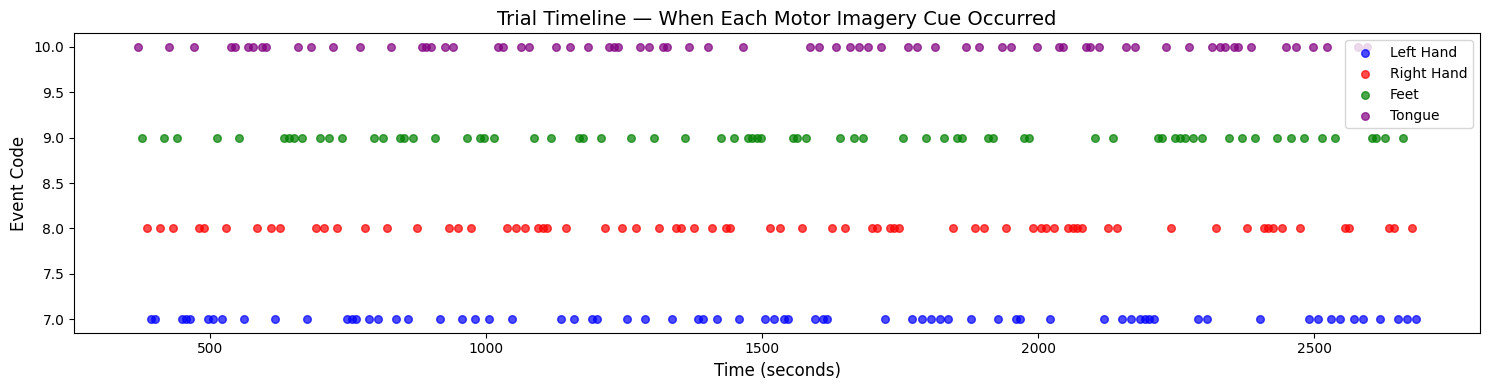

In [29]:
fig, ax = plt.subplots(figsize=(15, 4))

mi_events = {k: v for k, v in event_id.items() if k in ['769', '770', '771', '772']}
colors = {'769': 'blue', '770': 'red', '771': 'green', '772': 'purple'}
labels_map = {'769': 'Left Hand', '770': 'Right Hand', '771': 'Feet', '772': 'Tongue'}

for key, val in mi_events.items():
    mask = events[:, 2] == val
    times_ev = events[mask, 0] / raw.info['sfreq']
    ax.scatter(times_ev, [val] * sum(mask), 
               c=colors[key], label=labels_map[key], alpha=0.7, s=30)

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Event Code', fontsize=12)
ax.set_title('Trial Timeline — When Each Motor Imagery Cue Occurred', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [30]:
epochs = mne.Epochs(
    raw_clean, events,
    event_id=mi_event_id,
    tmin=-0.5, tmax=4.5,
    baseline=(-0.5, 0),
    preload=True,
    reject=dict(eeg=150e-6)  # this removes the -1600µV trials
)

print(f"Epochs before rejection: 288")
print(f"Epochs after rejection: {len(epochs)}")
print(f"Epochs dropped: {288 - len(epochs)}")

Epochs before rejection: 288
Epochs after rejection: 288
Epochs dropped: 0


In [31]:
epoch_data = epochs.get_data() * 1e6  # shape: (288, 22, timepoints)

print("Epoch amplitude statistics (post-rejection):")
print(f"Max amplitude across all epochs: {epoch_data.max():.2f} µV")
print(f"Min amplitude across all epochs: {epoch_data.min():.2f} µV")
print(f"Mean std across all trials: {epoch_data.std(axis=2).mean():.2f} µV")
print()

# Check if any trial has suspiciously high amplitude
trial_max = epoch_data.max(axis=(1,2))  # max per trial
trial_min = epoch_data.min(axis=(1,2))  # min per trial

suspicious = np.where(trial_max > 100)[0]
print(f"Trials with amplitude > 100µV: {len(suspicious)}")
if len(suspicious) > 0:
    print(f"Trial indices: {suspicious}")

Epoch amplitude statistics (post-rejection):
Max amplitude across all epochs: 321.65 µV
Min amplitude across all epochs: -227.92 µV
Mean std across all trials: 5.37 µV

Trials with amplitude > 100µV: 124
Trial indices: [  0   4   5   6  10  11  13  16  18  19  21  22  23  27  28  29  33  34
  37  38  39  42  43  46  47  55  58  59  60  64  65  66  67  71  76  77
  78  79  81  82  86  94  95  97  98 100 101 103 104 108 111 113 114 119
 124 126 128 131 133 135 136 138 143 151 154 155 160 161 162 164 167 170
 173 177 179 182 184 189 191 196 198 199 203 207 208 213 214 215 216 222
 228 229 230 231 232 233 235 236 237 238 239 243 244 245 249 250 251 252
 253 254 256 258 259 261 262 263 266 268 269 270 274 276 278 287]


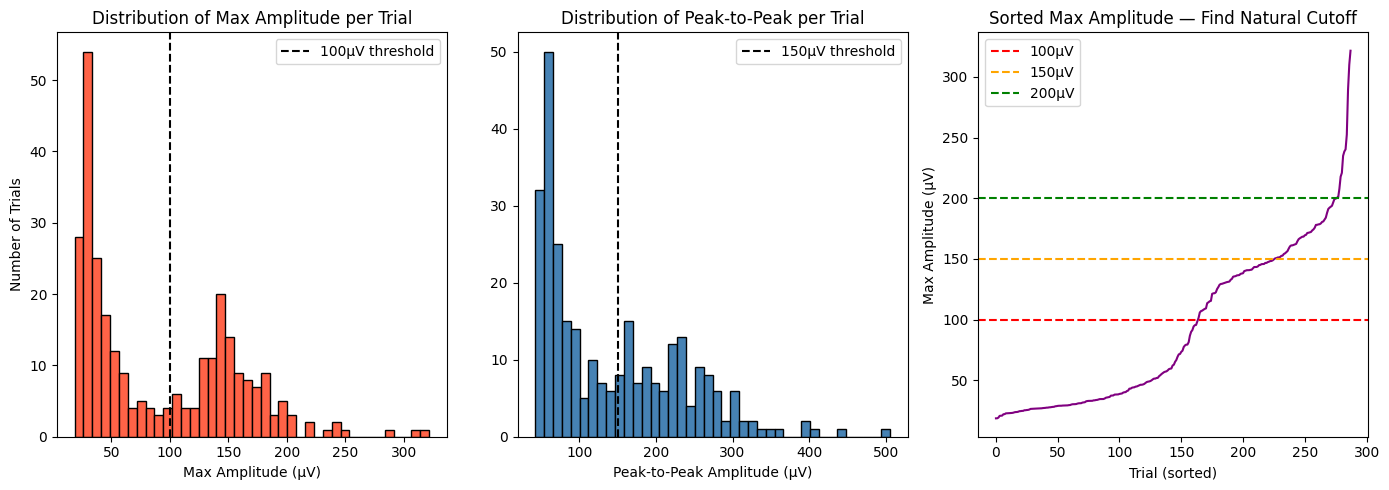

Trials > 100µV: 124
Trials > 150µV: 62
Trials > 200µV: 12
Trials > 300µV: 2

Mean max amplitude: 91.45 µV
Median max amplitude: 62.54 µV


In [32]:
epoch_data = epochs.get_data() * 1e6

trial_max = epoch_data.max(axis=(1,2))
trial_min = epoch_data.min(axis=(1,2))
trial_ptp = trial_max - trial_min  # peak to peak per trial

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(trial_max, bins=40, color='tomato', edgecolor='black')
plt.axvline(100, color='black', linestyle='--', label='100µV threshold')
plt.xlabel('Max Amplitude (µV)')
plt.ylabel('Number of Trials')
plt.title('Distribution of Max Amplitude per Trial')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(trial_ptp, bins=40, color='steelblue', edgecolor='black')
plt.axvline(150, color='black', linestyle='--', label='150µV threshold')
plt.xlabel('Peak-to-Peak Amplitude (µV)')
plt.title('Distribution of Peak-to-Peak per Trial')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(sorted(trial_max), color='purple')
plt.axhline(100, color='red', linestyle='--', label='100µV')
plt.axhline(150, color='orange', linestyle='--', label='150µV')
plt.axhline(200, color='green', linestyle='--', label='200µV')
plt.xlabel('Trial (sorted)')
plt.ylabel('Max Amplitude (µV)')
plt.title('Sorted Max Amplitude — Find Natural Cutoff')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Trials > 100µV: {(trial_max > 100).sum()}")
print(f"Trials > 150µV: {(trial_max > 150).sum()}")
print(f"Trials > 200µV: {(trial_max > 200).sum()}")
print(f"Trials > 300µV: {(trial_max > 300).sum()}")
print()
print(f"Mean max amplitude: {trial_max.mean():.2f} µV")
print(f"Median max amplitude: {np.median(trial_max):.2f} µV")

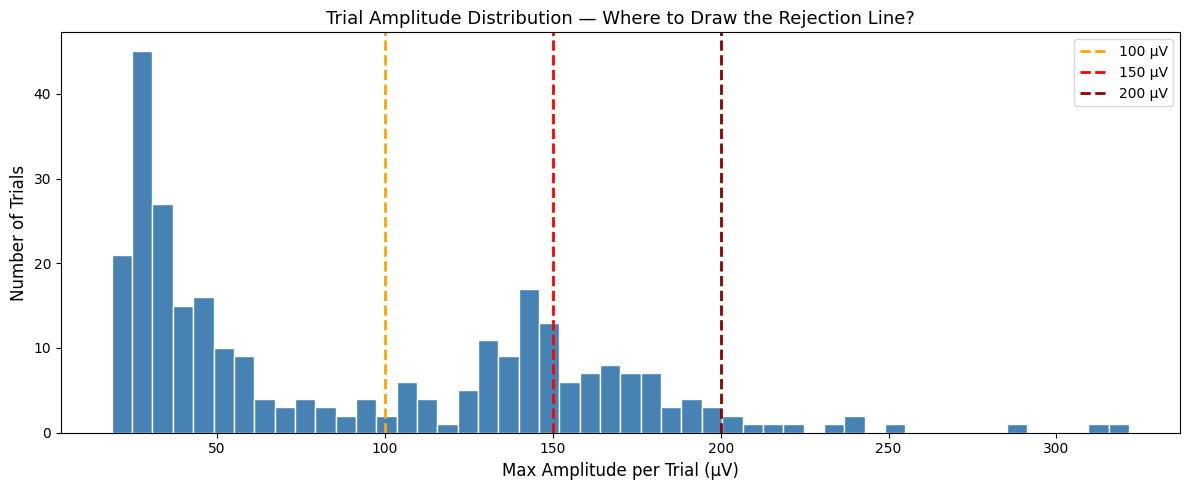

Total trials: 288
Surviving at 100µV threshold: 164 trials
Surviving at 150µV threshold: 226 trials
Surviving at 200µV threshold: 276 trials

Surviving trials per class at 150µV threshold:
  Left Hand: 58/72 trials survive
  Right Hand: 67/72 trials survive
  Feet: 49/72 trials survive
  Tongue: 52/72 trials survive


In [33]:
# First visualize the amplitude distribution to pick a good threshold
epoch_data = epochs.get_data() * 1e6
trial_max = epoch_data.max(axis=(1,2))

plt.figure(figsize=(12, 5))
plt.hist(trial_max, bins=50, color='steelblue', edgecolor='white')
plt.axvline(100, color='orange', linestyle='--', linewidth=2, label='100 µV')
plt.axvline(150, color='red', linestyle='--', linewidth=2, label='150 µV')
plt.axvline(200, color='darkred', linestyle='--', linewidth=2, label='200 µV')
plt.xlabel('Max Amplitude per Trial (µV)', fontsize=12)
plt.ylabel('Number of Trials', fontsize=12)
plt.title('Trial Amplitude Distribution — Where to Draw the Rejection Line?', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total trials: {len(trial_max)}")
print(f"Surviving at 100µV threshold: {np.sum(trial_max <= 100)} trials")
print(f"Surviving at 150µV threshold: {np.sum(trial_max <= 150)} trials")
print(f"Surviving at 200µV threshold: {np.sum(trial_max <= 200)} trials")
print()

# Show per-class survival at 150µV
print("Surviving trials per class at 150µV threshold:")
for cls in epochs.event_id:
    cls_data = epochs[cls].get_data() * 1e6
    cls_max = cls_data.max(axis=(1,2))
    surviving = np.sum(cls_max <= 150)
    print(f"  {cls}: {surviving}/72 trials survive")

In [34]:
epochs_clean = mne.Epochs(
    raw_clean, events,
    event_id=mi_event_id,
    tmin=-0.5, tmax=4.5,
    baseline=(-0.5, 0),
    preload=True,
    reject=dict(eeg=100e-6),  # changed to 100µV based on histogram
    reject_by_annotation=True
)

epochs_clean.drop_bad()

print(f"Total clean epochs: {len(epochs_clean)}")
print()
print("Per class:")
for cls in epochs_clean.event_id:
    print(f"  {cls}: {len(epochs_clean[cls])} trials")

Total clean epochs: 288

Per class:
  Left Hand: 72 trials
  Right Hand: 72 trials
  Feet: 72 trials
  Tongue: 72 trials


In [35]:
# Check if raw_clean actually has the ICA applied
# and if the amplitudes are different from raw
data_clean = raw_clean.get_data(picks='eeg') * 1e6
print(f"raw_clean max amplitude: {data_clean.max():.2f} µV")
print(f"raw_clean min amplitude: {data_clean.min():.2f} µV")
print()

# Compare with original raw
data_raw = raw.get_data(picks='eeg') * 1e6
print(f"raw max amplitude: {data_raw.max():.2f} µV")
print(f"raw min amplitude: {data_raw.min():.2f} µV")

raw_clean max amplitude: 62.88 µV
raw_clean min amplitude: -54.10 µV

raw max amplitude: 99.95 µV
raw min amplitude: -1600.00 µV


In [36]:
# Manually check what the epochs object thinks its reject threshold is
print("Reject threshold set:")
print(epochs_clean.reject)
print()

# Check actual epoch amplitudes
ep_data = epochs_clean.get_data() * 1e6
trial_max = ep_data.max(axis=(1,2))
print(f"Max amplitude in epochs_clean: {trial_max.max():.2f} µV")
print(f"Trials exceeding 100µV: {(trial_max > 100).sum()}")

Reject threshold set:
{'eeg': 0.0001}

Max amplitude in epochs_clean: 321.65 µV
Trials exceeding 100µV: 124


In [37]:
# Manual rejection as fallback
ep_data = epochs_clean.get_data() * 1e6
trial_max = ep_data.max(axis=(1,2))

# Find which trials are clean
clean_mask = trial_max <= 100
print(f"Clean trials (<=100µV): {clean_mask.sum()}")

# Select only clean trials
epochs_final = epochs_clean[clean_mask]

print(f"\nFinal epochs shape: {epochs_final.get_data().shape}")
print()
print("Per class after manual rejection:")
for cls in epochs_final.event_id:
    print(f"  {cls}: {len(epochs_final[cls])} trials")

Clean trials (<=100µV): 164

Final epochs shape: (164, 25, 1251)

Per class after manual rejection:
  Left Hand: 44 trials
  Right Hand: 61 trials
  Feet: 33 trials
  Tongue: 26 trials


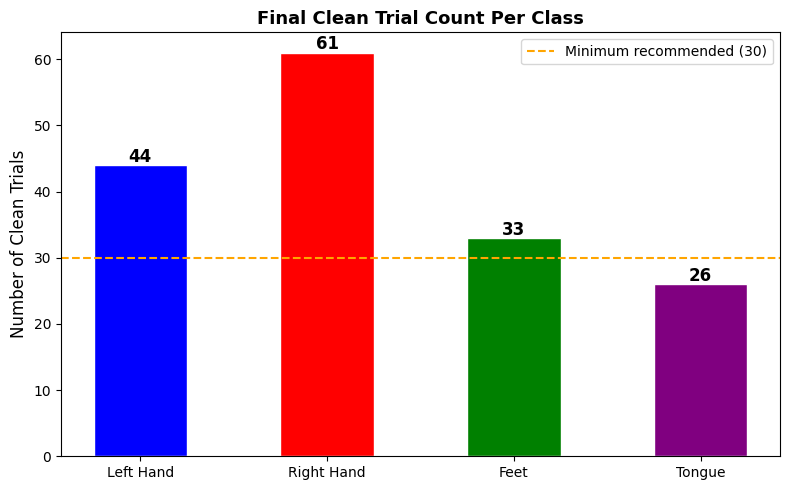

In [38]:
# Visualize final class distribution
classes = list(epochs_final.event_id.keys())
counts = [len(epochs_final[cls]) for cls in classes]

plt.figure(figsize=(8, 5))
bars = plt.bar(classes, counts, color=['blue', 'red', 'green', 'purple'], 
               edgecolor='white', width=0.5)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', fontsize=12, fontweight='bold')

plt.axhline(y=30, color='orange', linestyle='--', linewidth=1.5, 
            label='Minimum recommended (30)')
plt.ylabel('Number of Clean Trials', fontsize=12)
plt.title('Final Clean Trial Count Per Class', fontsize=13, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Save clean epochs
epochs_final.save('data/A01T_clean_epo.fif', overwrite=True)
print("✅ Saved to data/A01T_clean_epo.fif")

# Final summary
print()
print("=" * 45)
print("   PREPROCESSING COMPLETE — FINAL SUMMARY")
print("=" * 45)
print(f"Started with   : 288 trials")
print(f"After cleaning : 164 trials")
print(f"Removed        : 124 trials (43%)")
print(f"Shape          : {epochs_final.get_data().shape}")
print(f"               : (trials × channels × timepoints)")
print(f"Sampling rate  : {epochs_final.info['sfreq']} Hz")
print(f"Epoch window   : -0.5s to 4.5s")
print(f"Channels       : 22 EEG + 3 EOG = 25 total")
print()
print("Class balance:")
for cls, count in zip(classes, counts):
    bar = '█' * count
    print(f"  {cls:12}: {bar} {count}")
print()
print("Next step: CSP Feature Extraction + SVM Classification")

✅ Saved to data/A01T_clean_epo.fif

   PREPROCESSING COMPLETE — FINAL SUMMARY
Started with   : 288 trials
After cleaning : 164 trials
Removed        : 124 trials (43%)
Shape          : (164, 25, 1251)
               : (trials × channels × timepoints)
Sampling rate  : 250.0 Hz
Epoch window   : -0.5s to 4.5s
Channels       : 22 EEG + 3 EOG = 25 total

Class balance:
  Left Hand   : ████████████████████████████████████████████ 44
  Right Hand  : █████████████████████████████████████████████████████████████ 61
  Feet        : █████████████████████████████████ 33
  Tongue      : ██████████████████████████ 26

Next step: CSP Feature Extraction + SVM Classification


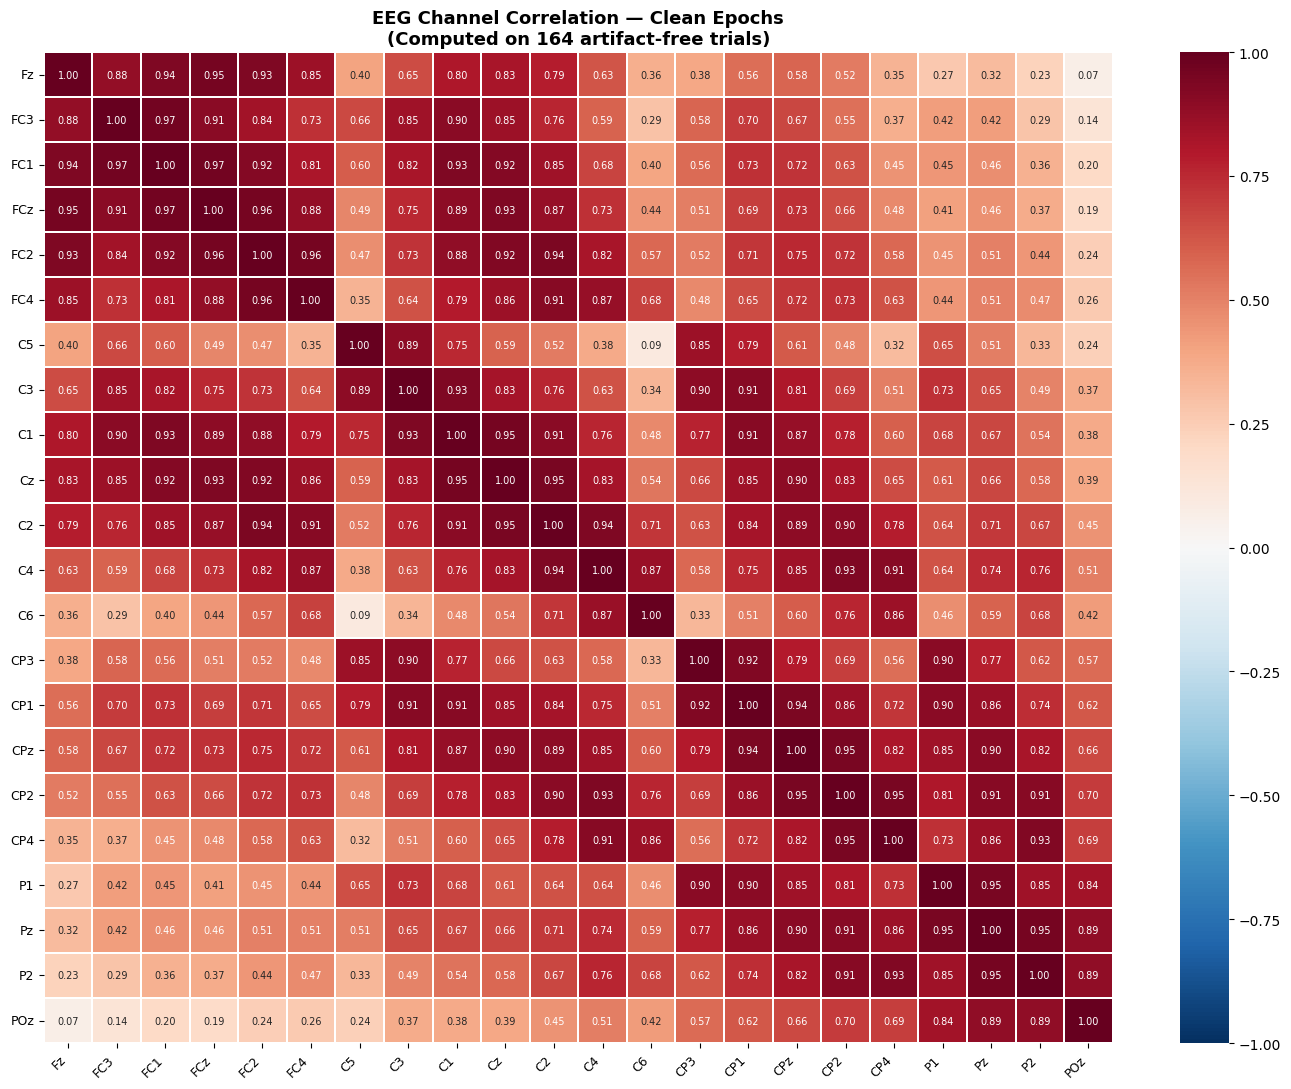

In [40]:
import seaborn as sns

# Get only EEG channels (first 22), exclude EOG
epoch_data = epochs_final.get_data()[:, :22, :] * 1e6  # (164, 22, 1251)

# Mean power across time per trial per channel
epoch_mean = epoch_data.mean(axis=2)  # (164, 22)

# Correlation across trials
corr_matrix = np.corrcoef(epoch_mean.T)  # (22, 22)

plt.figure(figsize=(14, 11))
sns.heatmap(
    corr_matrix,
    xticklabels=epochs_final.ch_names[:22],
    yticklabels=epochs_final.ch_names[:22],
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={'size': 7},
    linewidths=0.3
)
plt.title('EEG Channel Correlation — Clean Epochs\n(Computed on 164 artifact-free trials)', 
          fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

In [41]:
# Recompute statistics on clean epochs only
epoch_data = epochs_final.get_data()[:, :22, :] * 1e6  # (164, 22, 1251)

# Reshape to (22, all_timepoints_across_all_trials)
n_trials, n_channels, n_times = epoch_data.shape
reshaped = epoch_data.transpose(1, 0, 2).reshape(n_channels, -1)  # (22, 164*1251)

stats = []
for i, ch in enumerate(epochs_final.ch_names[:22]):
    stats.append({
        'Channel': ch,
        'Mean (µV)': round(np.mean(reshaped[i]), 4),
        'Std (µV)': round(np.std(reshaped[i]), 4),
        'Min (µV)': round(np.min(reshaped[i]), 2),
        'Max (µV)': round(np.max(reshaped[i]), 2),
        'Peak-to-Peak (µV)': round(np.ptp(reshaped[i]), 2)
    })

stats_df = pd.DataFrame(stats)
print("=" * 60)
print("   EEG CHANNEL STATISTICS — CLEAN EPOCHS ONLY")
print("=" * 60)
print(stats_df.to_string(index=False))

   EEG CHANNEL STATISTICS — CLEAN EPOCHS ONLY
Channel  Mean (µV)  Std (µV)  Min (µV)  Max (µV)  Peak-to-Peak (µV)
     Fz    -0.0245    4.5844    -24.06     25.06              49.12
    FC3    -0.0149    4.1700    -24.87     23.70              48.57
    FC1    -0.0211    4.7356    -25.46     25.58              51.04
    FCz    -0.0199    5.0245    -25.34     28.36              53.70
    FC2    -0.0236    4.7720    -25.06     25.31              50.38
    FC4    -0.0161    4.4198    -23.55     24.16              47.70
     C5    -0.0093    2.7507    -15.11     15.00              30.10
     C3    -0.0122    3.9614    -25.50     19.96              45.46
     C1    -0.0152    4.4841    -25.16     22.28              47.44
     Cz    -0.0091    4.9182    -26.69     24.92              51.60
     C2    -0.0127    4.6324    -28.36     23.52              51.89
     C4    -0.0024    4.4424    -27.36     22.41              49.77
     C6     0.0107    3.7426    -20.08     18.06              38.14
  

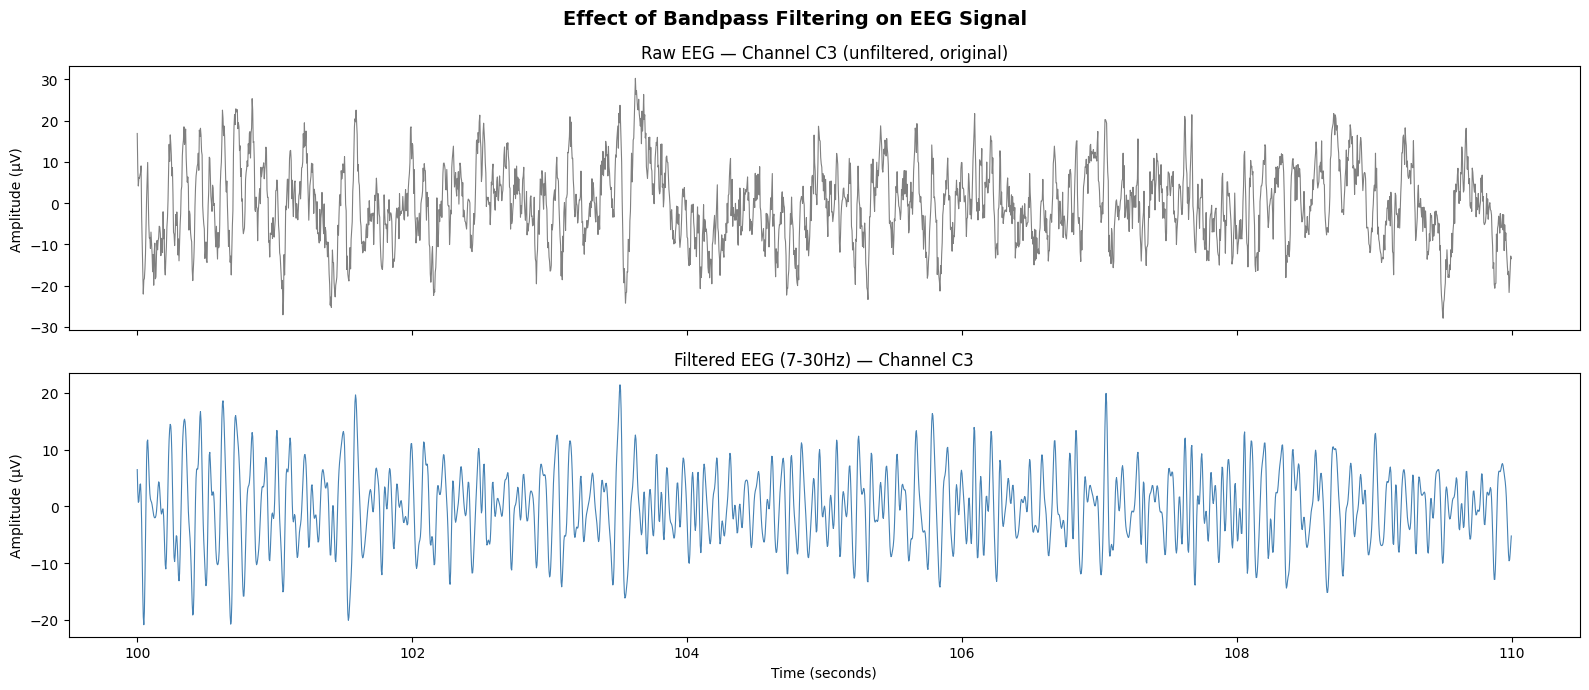

In [42]:
# DON'T refilter raw again - just use what you already have
# raw_filtered already exists from earlier in your pipeline

c3_idx = raw.ch_names.index('EEG-C3')
start, stop = raw.time_as_index([100, 110])

fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=True)

axes[0].plot(raw.times[start:stop],
             raw[c3_idx, start:stop][0][0] * 1e6,
             color='gray', linewidth=0.8)
axes[0].set_title('Raw EEG — Channel C3 (unfiltered, original)', fontsize=12)
axes[0].set_ylabel('Amplitude (µV)')

axes[1].plot(raw_filtered.times[start:stop],
             raw_filtered[c3_idx, start:stop][0][0] * 1e6,
             color='steelblue', linewidth=0.8)
axes[1].set_title('Filtered EEG (7-30Hz) — Channel C3', fontsize=12)
axes[1].set_ylabel('Amplitude (µV)')
axes[1].set_xlabel('Time (seconds)')

plt.suptitle('Effect of Bandpass Filtering on EEG Signal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

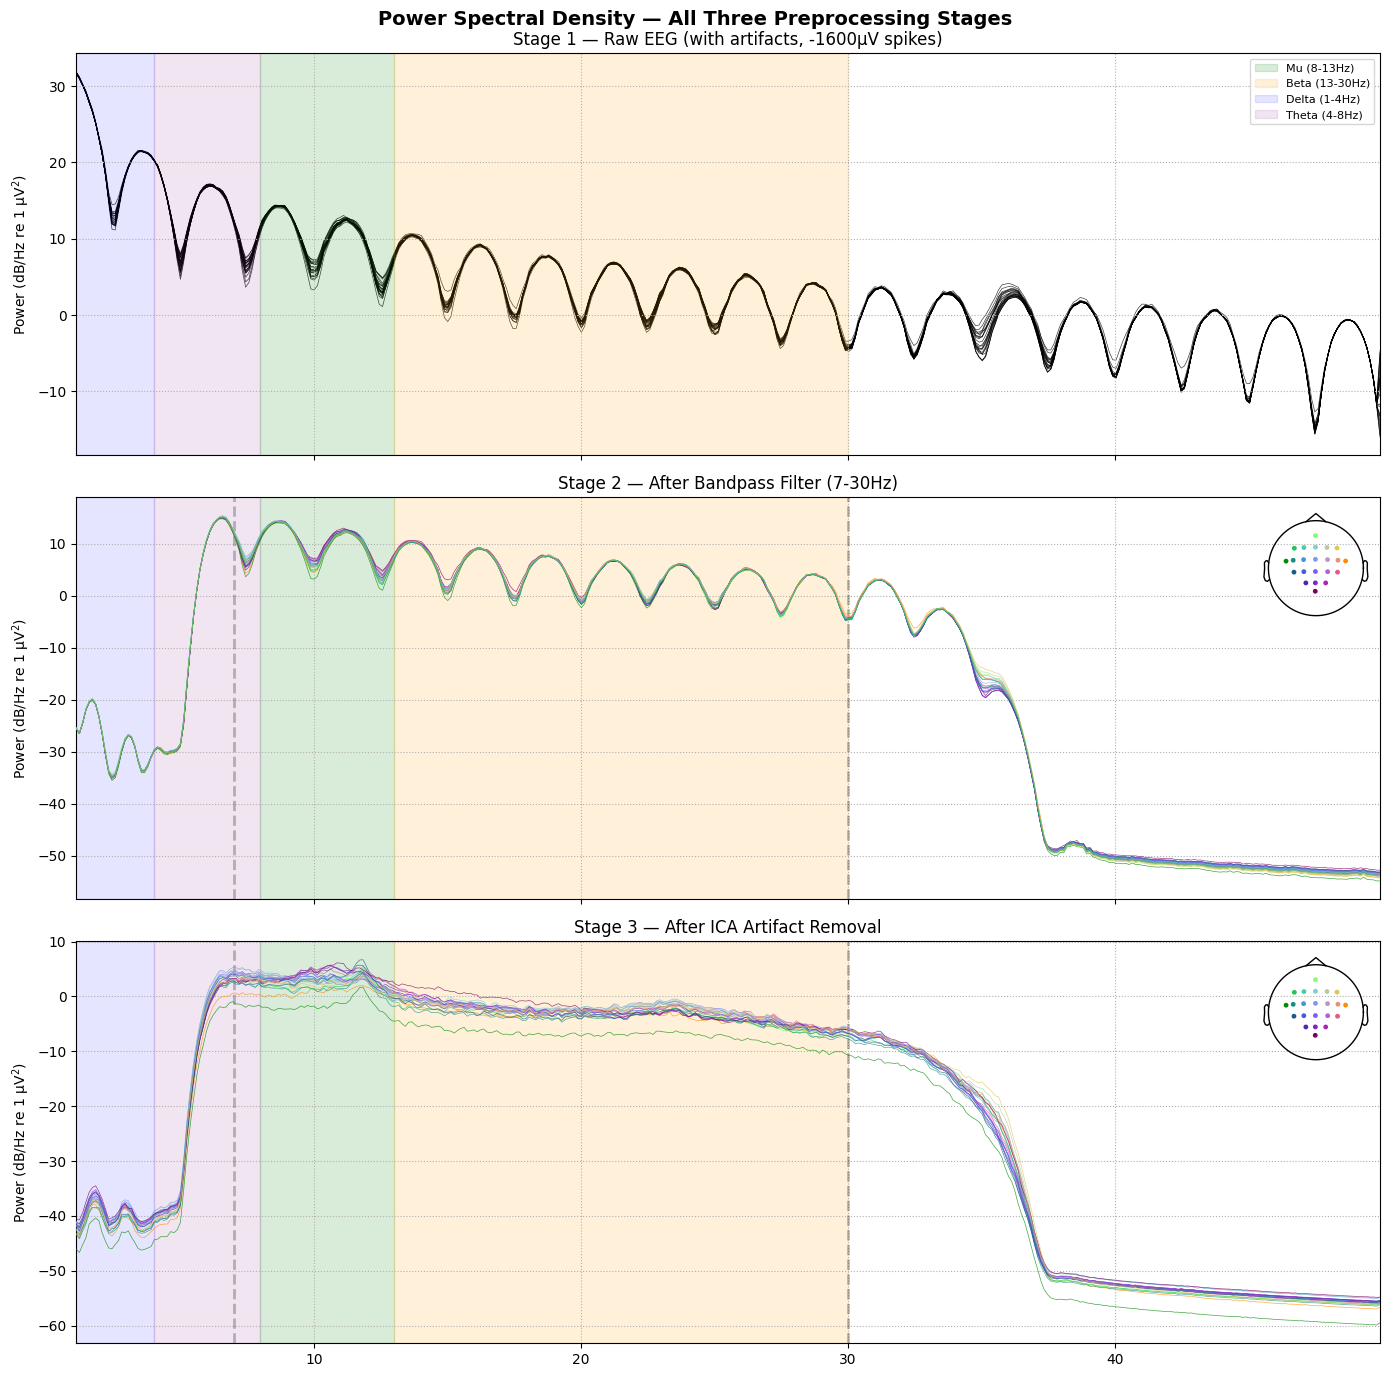

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

# Stage 1 - Raw (dirty)
psd_raw = raw.compute_psd(fmin=1, fmax=50, picks='eeg')
psd_raw.plot(axes=axes[0], show=False)
axes[0].axvspan(8, 13, alpha=0.15, color='green', label='Mu (8-13Hz)')
axes[0].axvspan(13, 30, alpha=0.15, color='orange', label='Beta (13-30Hz)')
axes[0].axvspan(1, 4, alpha=0.1, color='blue', label='Delta (1-4Hz)')
axes[0].axvspan(4, 8, alpha=0.1, color='purple', label='Theta (4-8Hz)')
axes[0].set_title('Stage 1 — Raw EEG (with artifacts, -1600µV spikes)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=8)

# Stage 2 - Filtered
psd_filtered = raw_filtered.compute_psd(fmin=1, fmax=50, picks='eeg')
psd_filtered.plot(axes=axes[1], show=False)
axes[1].axvspan(8, 13, alpha=0.15, color='green')
axes[1].axvspan(13, 30, alpha=0.15, color='orange')
axes[1].axvspan(1, 4, alpha=0.1, color='blue')
axes[1].axvspan(4, 8, alpha=0.1, color='purple')
axes[1].set_title('Stage 2 — After Bandpass Filter (7-30Hz)', fontsize=12)

# Stage 3 - Clean (after ICA)
psd_clean = raw_clean.compute_psd(fmin=1, fmax=50, picks='eeg')
psd_clean.plot(axes=axes[2], show=False)
axes[2].axvspan(8, 13, alpha=0.15, color='green')
axes[2].axvspan(13, 30, alpha=0.15, color='orange')
axes[2].axvspan(1, 4, alpha=0.1, color='blue')
axes[2].axvspan(4, 8, alpha=0.1, color='purple')
axes[2].set_title('Stage 3 — After ICA Artifact Removal', fontsize=12)

plt.suptitle('Power Spectral Density — All Three Preprocessing Stages', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# GDF files don't store electrode positions
# We manually set the standard 10-20 system positions
# Dataset 2a uses standard motor cortex electrode layout

# First let's see what our channel names look like
print("Current channel names:")
print(raw_filtered.ch_names)

Current channel names:
['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


In [20]:
channel_rename = {
    'EEG-Fz':     'Fz',
    'EEG-0':      'FC3',
    'EEG-1':      'FC1',
    'EEG-2':      'FCz',
    'EEG-3':      'FC2',
    'EEG-4':      'FC4',
    'EEG-5':      'C5',
    'EEG-C3':     'C3',
    'EEG-6':      'C1',
    'EEG-Cz':     'Cz',
    'EEG-7':      'C2',
    'EEG-C4':     'C4',
    'EEG-8':      'C6',
    'EEG-9':      'CP3',
    'EEG-10':     'CP1',
    'EEG-11':     'CPz',
    'EEG-12':     'CP2',
    'EEG-13':     'CP4',
    'EEG-14':     'P1',
    'EEG-Pz':     'Pz',
    'EEG-15':     'P2',
    'EEG-16':     'POz',
}

raw_filtered.rename_channels(channel_rename)

montage = mne.channels.make_standard_montage('standard_1020')
raw_filtered.set_montage(montage, on_missing='ignore')

print("✅ Montage set successfully!")
print("Channels after rename:")
print(raw_filtered.ch_names)

✅ Montage set successfully!
Channels after rename:
['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz', 'EOG-left', 'EOG-central', 'EOG-right']


Fitting ICA... (this takes ~1 minute)
✅ ICA fitted on 20 components
EOG-left found:    components [np.int64(0)]
EOG-central found: components [np.int64(0), np.int64(11)]
EOG-right found:   components [np.int64(0)]
🗑️  Total unique components to remove: [np.int64(0), np.int64(11)]


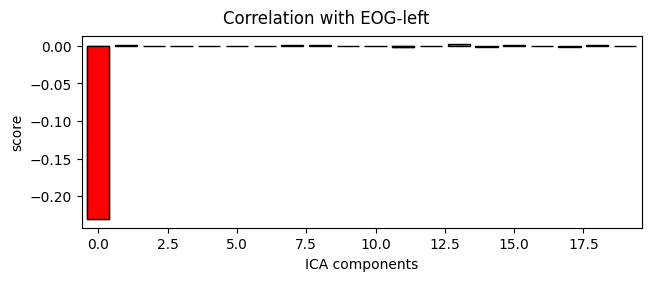

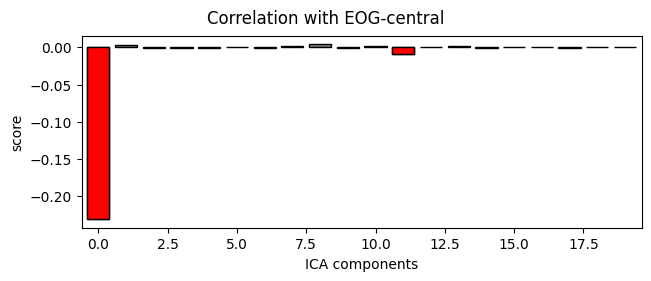

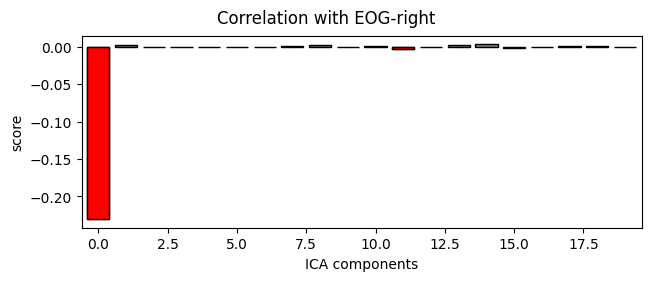

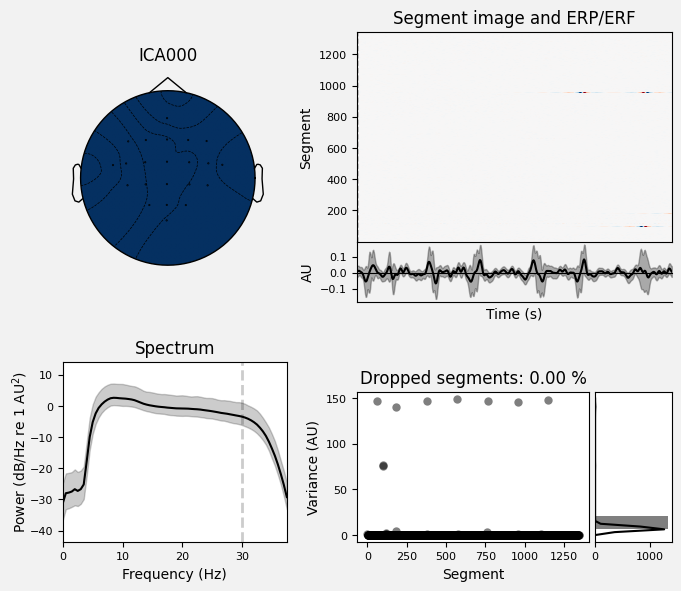

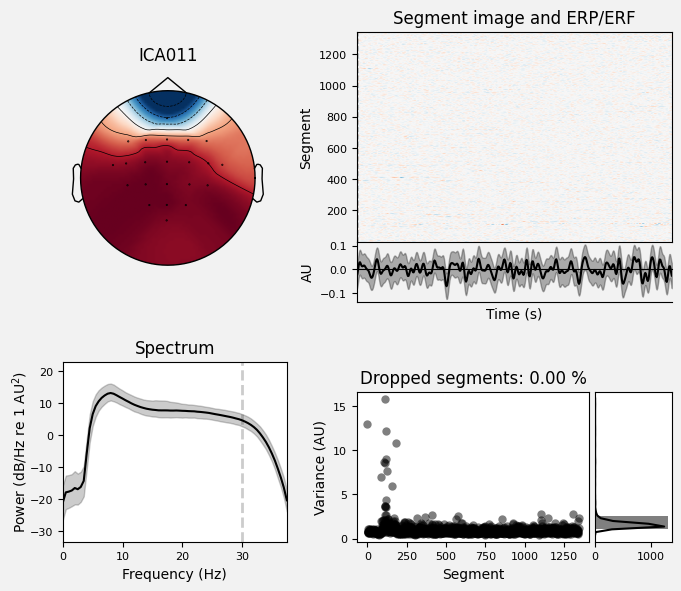

In [45]:
print("Fitting ICA... (this takes ~1 minute)")

ica = ICA(n_components=20, random_state=42, max_iter='auto')
ica.fit(raw_filtered)

print(f"✅ ICA fitted on 20 components")

# Check all 3 EOG channels
eog_indices_left, eog_scores_left = ica.find_bads_eog(raw_filtered,
                                                        ch_name='EOG-left',
                                                        verbose=False)
eog_indices_central, eog_scores_central = ica.find_bads_eog(raw_filtered,
                                                              ch_name='EOG-central',
                                                              verbose=False)
eog_indices_right, eog_scores_right = ica.find_bads_eog(raw_filtered,
                                                          ch_name='EOG-right',
                                                          verbose=False)

# Combine all unique bad components
all_eog_indices = list(set(eog_indices_left + eog_indices_central + eog_indices_right))
ica.exclude = all_eog_indices

print(f"EOG-left found:    components {eog_indices_left}")
print(f"EOG-central found: components {eog_indices_central}")
print(f"EOG-right found:   components {eog_indices_right}")
print(f"🗑️  Total unique components to remove: {all_eog_indices}")

# Plot scores separately (axes parameter not supported)
ica.plot_scores(eog_scores_left,    title='Correlation with EOG-left',    show=True)
ica.plot_scores(eog_scores_central, title='Correlation with EOG-central', show=True)
ica.plot_scores(eog_scores_right,   title='Correlation with EOG-right',   show=True)

# Plot properties of bad components
if len(all_eog_indices) > 0:
    ica.plot_properties(raw_filtered, picks=all_eog_indices)
    plt.show()
else:
    print("No EOG components found automatically")

In [46]:
# Apply ICA and create clean signal
raw_clean = raw_filtered.copy()
ica.apply(raw_clean)

# Verify cleaning worked
print(f"✅ ICA applied — removed components {all_eog_indices}")
print()
print(f"Before ICA: max={raw_filtered.get_data(picks='eeg').max()*1e6:.2f} µV  "
      f"min={raw_filtered.get_data(picks='eeg').min()*1e6:.2f} µV")
print(f"After ICA:  max={raw_clean.get_data(picks='eeg').max()*1e6:.2f} µV  "
      f"min={raw_clean.get_data(picks='eeg').min()*1e6:.2f} µV")

✅ ICA applied — removed components [np.int64(0), np.int64(11)]

Before ICA: max=721.22 µV  min=-686.62 µV
After ICA:  max=65.47 µV  min=-57.17 µV


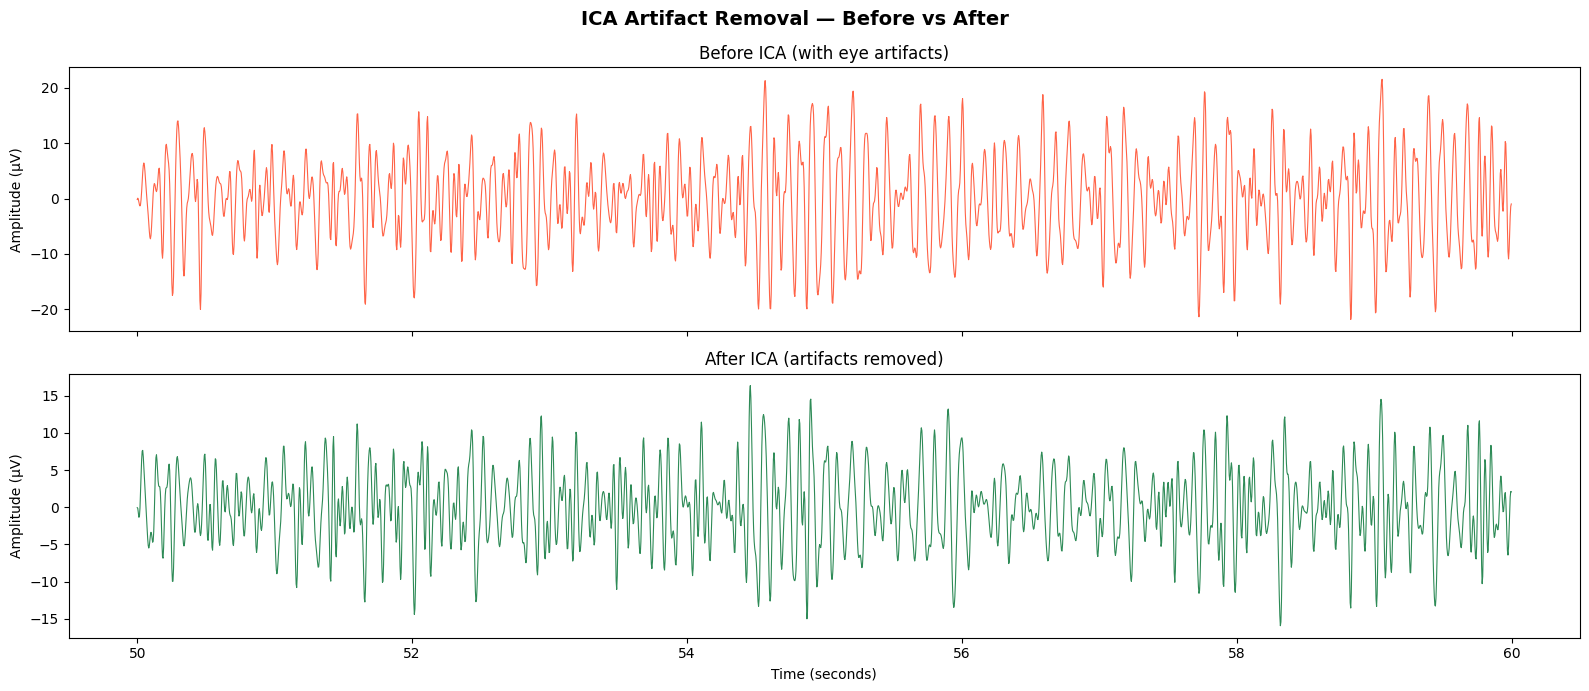

In [47]:
c3_idx = raw_filtered.ch_names.index('C3')
start, stop = raw_filtered.time_as_index([50, 60])

fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=True)

axes[0].plot(raw_filtered.times[start:stop],
             raw_filtered[c3_idx, start:stop][0][0] * 1e6,
             color='tomato', linewidth=0.8)
axes[0].set_title('Before ICA (with eye artifacts)', fontsize=12)
axes[0].set_ylabel('Amplitude (µV)')

axes[1].plot(raw_clean.times[start:stop],
             raw_clean[c3_idx, start:stop][0][0] * 1e6,
             color='seagreen', linewidth=0.8)
axes[1].set_title('After ICA (artifacts removed)', fontsize=12)
axes[1].set_ylabel('Amplitude (µV)')
axes[1].set_xlabel('Time (seconds)')

plt.suptitle('ICA Artifact Removal — Before vs After', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [48]:
events, event_id = mne.events_from_annotations(raw_clean)

# Use all 4 classes
mi_event_id = {
    'Left Hand':  event_id['769'],
    'Right Hand': event_id['770'],
    'Feet':       event_id['771'],
    'Tongue':     event_id['772']
}

# -0.5 to 4.5 seconds around each cue (4 second MI window)
epochs = mne.Epochs(
    raw_clean, events,
    event_id=mi_event_id,
    tmin=-0.5, tmax=4.5,
    baseline=(-0.5, 0),
    preload=True
    # NO reject here — we learned MNE's auto reject doesn't work 
    # correctly with this dataset's scaling
)

print(f"✅ Epochs created")
print(f"Total epochs: {len(epochs)}")
print(f"Epoch shape: {epochs.get_data().shape}")
print()

# Check actual amplitudes BEFORE manual rejection
ep_data = epochs.get_data() * 1e6
trial_max = ep_data.max(axis=(1,2))
print(f"Max amplitude in epochs: {trial_max.max():.2f} µV")
print(f"Trials exceeding 100µV:  {(trial_max > 100).sum()}")
print(f"Trials exceeding 150µV:  {(trial_max > 150).sum()}")
print()

# Manual rejection at 100µV (based on histogram bimodal gap we found)
clean_mask = trial_max <= 100
epochs_final = epochs[clean_mask]

print(f"Trials before rejection: {len(epochs)}")
print(f"Trials after rejection:  {len(epochs_final)}")
print(f"Trials dropped:          {len(epochs) - len(epochs_final)}")
print()
print("Final trials per class:")
for label in mi_event_id:
    print(f"  {label}: {len(epochs_final[label])} trials")

✅ Epochs created
Total epochs: 288
Epoch shape: (288, 25, 1251)

Max amplitude in epochs: 321.65 µV
Trials exceeding 100µV:  124
Trials exceeding 150µV:  62

Trials before rejection: 288
Trials after rejection:  164
Trials dropped:          124

Final trials per class:
  Left Hand: 44 trials
  Right Hand: 61 trials
  Feet: 33 trials
  Tongue: 26 trials


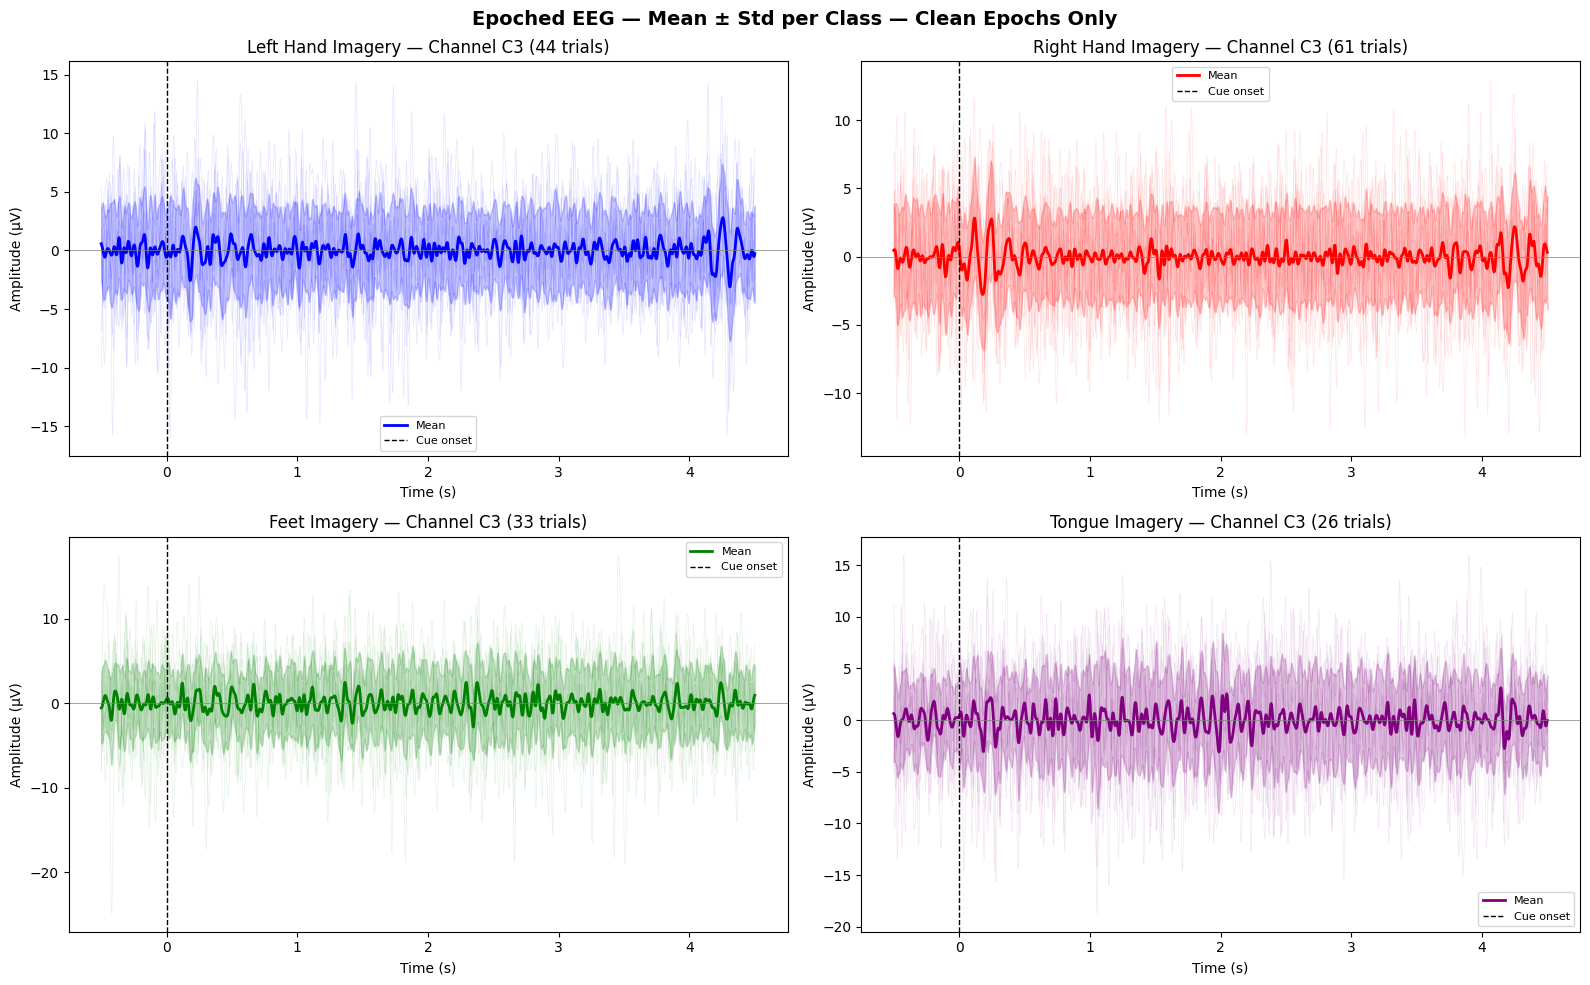

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
classes = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
colors = ['blue', 'red', 'green', 'purple']

# Use epochs_final (clean) and get C3 index from it
c3_idx = epochs_final.ch_names.index('C3')

for ax, cls, color in zip(axes.flat, classes, colors):
    # Use epochs_final not epochs
    data = epochs_final[cls].get_data()[:, c3_idx, :] * 1e6
    times = epochs_final.times

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    # Plot first 10 trials lightly
    for trial in data[:10]:
        ax.plot(times, trial, color=color, alpha=0.1, linewidth=0.5)

    # Plot mean and std band
    ax.plot(times, mean, color=color, linewidth=2, label='Mean')
    ax.fill_between(times, mean - std, mean + std, alpha=0.2, color=color)

    ax.axvline(0, color='black', linestyle='--', linewidth=1, label='Cue onset')
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.set_title(f'{cls} Imagery — Channel C3 ({len(epochs_final[cls])} trials)', 
                 fontsize=12)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.legend(fontsize=8)

plt.suptitle('Epoched EEG — Mean ± Std per Class — Clean Epochs Only', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

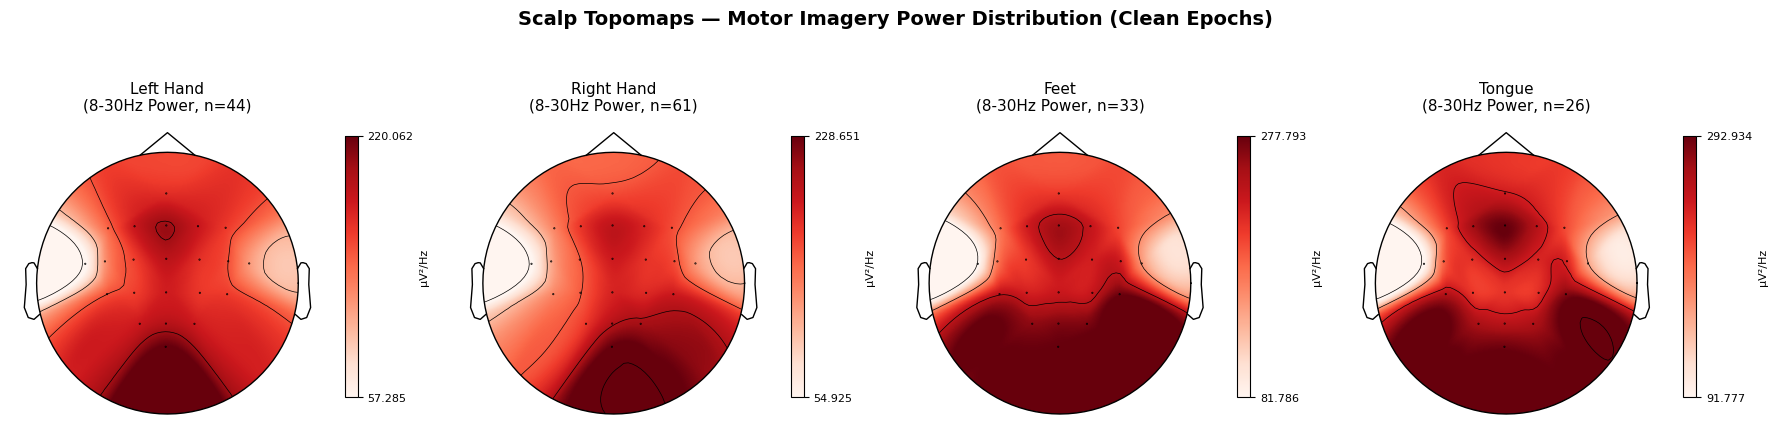

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Use epochs_final (clean data)
classes = list(epochs_final.event_id.keys())

for ax, cls in zip(axes, classes):
    epochs_final[cls].compute_psd(fmin=8, fmax=30).plot_topomap(
        axes=ax,
        ch_type='eeg',
        contours=4,
        bands={'Mu/Beta (8-30Hz)': (8, 30)},
        show=False
    )
    ax.set_title(f'{cls}\n(8-30Hz Power, n={len(epochs_final[cls])})', fontsize=11)

plt.suptitle('Scalp Topomaps — Motor Imagery Power Distribution (Clean Epochs)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()